# Bioinformatics software

## PubMed API Entrez Interactions

In [608]:
from datetime import datetime
import json
import re
import time

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import warnings
import xmltodict

%reload_ext autoreload
%autoreload 2
import pbmd_tools as pbmd

#### Using Esearch to get the list of IDs of the articles containing "github.com" in their abstract

In [609]:
API_KEY = pbmd.read_tokens()[0]
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
nresults = 15000
retmode = "json"
queries = []
for i in range(2009,2024):
    queries.append(f'((github.com[Title/Abstract])) AND (("{i}/01/01"[Date - Publication] : "{i}/12/31"[Date - Publication]))')

In [610]:
PMIDs = []
stats = {}
for query in tqdm(queries):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmax={nresults}&retmode={retmode}&term={query}&api_key={API_KEY}"
    response = requests.get(queryLinkSearch)
    pubmedJson = response.json()
    for id in pubmedJson["esearchresult"]["idlist"]:
        nb += 1
        PMIDs.append(id)
    stats[query[38:42]] = nb
PMIDs = set(PMIDs)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.09it/s]


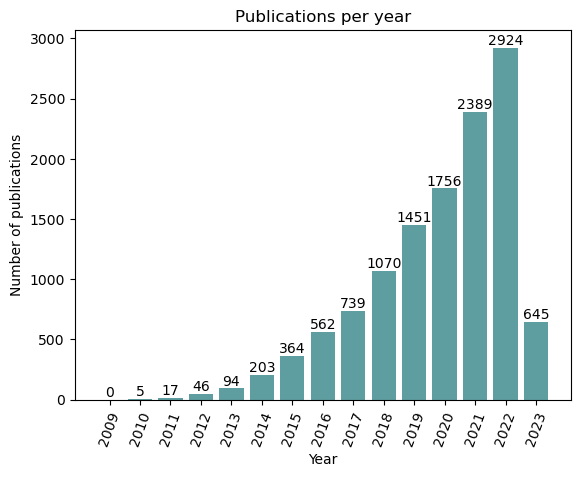

In [611]:
years = list(stats.keys())
values = list(stats.values())

plt.bar(years, values, color='cadetblue')

plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.title('Publications per year')

for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=70)

plt.show()

In [612]:
with open("PMIDs.txt", "w") as f:
    for PMID in PMIDs:
        f.write(str(PMID)+"\n")

In [ ]:
# https://pubmed.ncbi.nlm.nih.gov/26262258/ - No DOI in PubMed although there is one in the full text of the article (not from ArXiv), and there are a lot of them
# https://pubmed.ncbi.nlm.nih.gov/28269829/ - they give a wrong link https://github.com/SBU-BMI/imageboxs://github.com/SBU-BMI/imagebox but if you use this link :
# https://github.com/SBU-BMI/imagebox it works. Yet, i am not sure that it is actually what we are looking for since they also provide another link to github.io 
# (also incorect) and i think it's more likely that their code is there

#### Using Efetch to get all the necessary information about these articles

In [615]:
results = []
log_error_sum = []
for PMID in tqdm(PMIDs):
        results.append(pbmd.get_info(PMID, log_error_sum)[:-1])

100%|██████████████████████████████████████████████████████████████████████████| 11502/11502 [1:56:16<00:00,  1.65it/s]


In [616]:
df1 = pd.DataFrame.from_records(results)
df1 = df1.rename(columns={0: 'PubDate', 1: 'DOI', 2: 'Journal', 3: 'Title', 4: 'Abstract'})
new_column = pd.read_csv('PMIDs.txt', header=None, names=['PMID'], lineterminator='\n')
df1.insert(loc=0, column='PMID', value=new_column)

df1[df1.isnull().any(axis=1)]

,PMID,PubDate,DOI,Journal,Title,Abstract
40,34343090,None,10.1109/TIP.2021.3099366,IEEE transactions on image processing : a publ...,Global Aggregation Then Local Distribution for...,Modelling long-range contextual relationships ...
207,29752479,None,10.1038/s41593-018-0117-1,Nature neuroscience,Publisher Correction: Genome-wide association ...,In the version of this article initially publi...
325,31797632,2021-02-15,None,Pacific Symposium on Biocomputing. Pacific Sym...,PGxMine: Text mining for curation of PharmGKB.,Precision medicine tailors treatment to indivi...
368,36349348,2022-06-23,None,The journal of machine learning for biomedical...,Joint Frequency and Image Space Learning for M...,We propose neural network layers that explicit...
443,28968704,None,10.1093/bioinformatics/btx575,"Bioinformatics (Oxford, England)",SINCERITIES: inferring gene regulatory network...,Single cell transcriptional profiling opens up...
...,...,...,...,...,...,...
11152,29795769,None,10.5334/jors.207,Journal of open research software,InDEx: Open Source iOS and Android Software fo...,InDEx is a software package for reporting and ...
11178,35997564,None,None,None,None,None
11257,36847450,None,10.1093/bioinformatics/btad104,"Bioinformatics (Oxford, England)",Haptools: a toolkit for admixture and haplotyp...,Leveraging local ancestry and haplotype inform...
11283,34423306,None,None,Proceedings of machine learning research,Fold2Seq: A Joint Sequence(1D)-Fold(3D) Embedd...,Designing novel protein sequences for a desire...


In [617]:
df1.to_csv('articles.tsv', sep='\t', index=False)

In [618]:
with open("errors_pubmed.txt", "w") as f:
    for line in log_error_sum:
        f.write(line)

## Cleaning obtained data

In [ ]:
df1 = pd.read_csv('articles.tsv', sep='\t')

In [622]:
df1['GitHub_link_raw'] = df1['Abstract'].astype(str).apply(pbmd.get_link)
df1['GitHub_link_clean'] = df1['GitHub_link_raw'].astype(str).apply(pbmd.clean_link)

In [623]:
df1

,PMID,PubDate,DOI,Journal,Title,Abstract,GitHub_link_raw,GitHub_link_clean
0,33953661,2021-03-18,10.1107/S1600576721000674,Journal of applied crystallography,MATSAS : a small-angle scattering computing to...,is a script-based MATLAB program for analysis ...,github.com/matsas-software/MATSAS,https://github.com/matsas-software/MATSAS/
1,36304335,2022-10-10,10.3389/fbinf.2022.1019597,Frontiers in bioinformatics,SETH predicts nuances of residue disorder from...,Predictions for millions of protein three-dime...,github.com/Rostlab/SETH.,https://github.com/Rostlab/SETH/
2,30336361,2019-10-07,10.1016/j.compbiomed.2018.10.005,Computers in biology and medicine,iRecSpot-EF: Effective sequence based features...,"In genetic evolution, meiotic recombination pl...",github.com/mrzResearchArena/iRecSpot.,https://github.com/mrzResearchArena/iRecSpot/
3,31835003,2021-07-26,10.1162/neco_a_01255,Neural computation,Transition Scale-Spaces: A Computational Theor...,Although hippocampal grid cells are thought to...,github.com/rochus/transitionscalespace.,https://github.com/rochus/transitionscalespace/
4,25372389,2015-07-23,10.1371/journal.pone.0110289,PloS one,SlideToolkit: an assistive toolset for the his...,The demand for accurate and reproducible pheno...,github.com.,https://github.com/
...,...,...,...,...,...,...,...,...
11497,27602267,2016-09-07,10.7717/peerj.2279,PeerJ,Microbe-ID: an open source toolbox for microbi...,"Development of tools to identify species, geno...",github.com/grunwaldlab/Microbe-ID.,https://github.com/grunwaldlab/Microbe-ID/
11498,34324563,2021-08-06,10.1371/journal.pone.0255270,PloS one,Topological network based drug repurposing for...,The COVID-19 pandemic caused by the Severe Acu...,github.com/MahnazHabibi/Drug-repurposing.,https://github.com/MahnazHabibi/Drug-repurposi...
11499,35426900,2022-11-14,10.1093/bioinformatics/btac274,"Bioinformatics (Oxford, England)",DRUMMER-rapid detection of RNA modifications t...,The chemical modification of ribonucleotides r...,github.com/DepledgeLab/DRUMMER.,https://github.com/DepledgeLab/DRUMMER/
11500,33493117,2021-07-23,10.1109/TIP.2021.3052364,IEEE transactions on image processing : a publ...,Towards Fine-Grained Human Pose Transfer With ...,Human pose transfer (HPT) is an emerging resea...,github.com/Lotayou/RATE.,https://github.com/Lotayou/RATE/


In [624]:
df1.to_csv('articles_with_links.tsv', sep='\t', index=False)

## GitHub API Interactions

In [625]:
#To find out about repositories that were not accessed, consult the log_error variable. 

df1["Repo_created_at"] = None
df1["Repo_updated_at"] = None
log_error_repo = []
for i in tqdm(range(len(df1["PMID"]))):
    try:
        df1["Repo_created_at"].iloc[i], df1["Repo_updated_at"].iloc[i], log_error_repo = pbmd.get_repo_info(str(df1["GitHub_link_clean"].iloc[i]), log_error_repo)
    except:
        log_error_repo.append(f"Error with PMID: {df1['PMID'][i]}\n")
        continue
df1 = df1.reindex(columns=["PMID", "PubDate", "Repo_created_at", "Repo_updated_at", "DOI", "Journal", "Title", "GitHub_link_raw", "GitHub_link_clean", "Abstract"])

  0%|                                                                                        | 0/11502 [00:00<?, ?it/s]C:\Users\nadia\AppData\Local\Temp\ipykernel_19028\3119804100.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Repo_created_at"].iloc[i], df1["Repo_updated_at"].iloc[i], log_error_repo = pbmd.get_repo_info(str(df1["GitHub_link_clean"].iloc[i]), log_error_repo)
100%|██████████████████████████████████████████████████████████████████████████| 11502/11502 [1:03:48<00:00,  3.00it/s]


In [626]:
with open("errors_github.txt", "w") as f:
    for line in log_error_repo:
        f.write(line)

In [627]:
df1.to_csv('articles_with_dates.tsv', sep='\t', index=False)

In [628]:
df1[df1['Repo_created_at'].isna()]

,PMID,PubDate,Repo_created_at,Repo_updated_at,DOI,Journal,Title,GitHub_link_raw,GitHub_link_clean,Abstract
4,25372389,2015-07-23,None,None,10.1371/journal.pone.0110289,PloS one,SlideToolkit: an assistive toolset for the his...,github.com.,https://github.com/,The demand for accurate and reproducible pheno...
66,28714590,2018-01-30,None,None,10.1002/gepi.22059,Genetic epidemiology,Adaptive testing for association between two r...,github.com/jasonzyx/aSPC.,https://github.com/jasonzyx/aSPC/,Testing for association between two random vec...
80,32938494,2021-08-11,None,None,10.1186/s13062-020-00267-2,Biology direct,AMDock: a versatile graphical tool for assisti...,github.com/Valdes-Tresanco-MS,https://github.com/Valdes-Tresanco-MS/,AMDock (Assisted Molecular Docking) is a user-...
168,35452387,2022-05-30,None,None,10.1109/TUFFC.2022.3169684,"IEEE transactions on ultrasonics, ferroelectri...",LVNet: Lightweight Model for Left Ventricle Se...,github.com/navchetanawasthi/Left_Ventricle_Seg...,https://github.com/navchetanawasthi/Left_Ventr...,Lightweight segmentation models are becoming m...
204,36315552,2022-11-16,None,None,10.1109/TIP.2022.3216995,IEEE transactions on image processing : a publ...,SiamHYPER: Learning a Hyperspectral Object Tra...,github.com,https://github.com/,"Hyperspectral videos can provide the spatial, ..."
...,...,...,...,...,...,...,...,...,...,...
11393,26124555,2015-06-30,None,None,10.6026/97320630011173,Bioinformation,BlastXtract2: Improving early exploration of (...,github.com/,https://github.com/,To manage and intelligently mine the avalanche...
11407,29649301,2018-07-18,None,None,10.1371/journal.pone.0195557,PloS one,pyBadlands: A framework to simulate sediment t...,github.com/badlands-model,https://github.com/badlands-model/,Understanding Earth surface responses in terms...
11429,29994594,2018-02-27,None,None,10.1109/TCYB.2018.2803217,IEEE transactions on cybernetics,Multiobject Tracking by Submodular Optimization.,github.com/shenjianbing/submodulartrack.,https://github.com/shenjianbing/submodulartrack/,"In this paper, we propose a new multiobject vi..."
11447,27884106,2017-07-18,None,None,10.1186/s12859-016-1355-4,BMC bioinformatics,SPECtre: a spectral coherence--based classifie...,github.com/mills-lab/spectreok,https://github.com/mills-lab/spectreok/,Active protein translation can be assessed and...


In [275]:
# PMID = 36789260 - 2 links
#https://github.com/tyqGitHub/TYQ/tree/master/GACNNMDA - ????
#https://github.com/mofradlab - ?????? (PMID 36786404)
# PMID = 26124555 - a space in the link
# PMID = 24324759, 22151646 - no space after link
# PMID = 23849037 - why + in the end ?
# PMID = 36315552 - super smart

## Visualization of time spent working on software

In [635]:
df = pd.DataFrame()
df["PubDate"] = pd.to_datetime(df1["PubDate"])
df["Repo_created_at"] = pd.to_datetime(df1["Repo_created_at"])
df["Repo_updated_at"] = pd.to_datetime(df1["Repo_updated_at"])
df["Repo_created_at"] = (df["Repo_created_at"] - df["PubDate"]).dt.days
df["Repo_updated_at"] = (df["Repo_updated_at"] - df["PubDate"]).dt.days
df["PubDate"] = 0
df["Updates"] = df.apply(lambda row: 1 if row["Repo_updated_at"] > 30 else 0, axis=1)

In [636]:
df = df.dropna(how='any')
df = df.sort_values(by=['Repo_created_at', 'Repo_updated_at'], ascending=[True, True])
df = df.reset_index(drop=True)

5312it [00:06, 861.22it/s] 


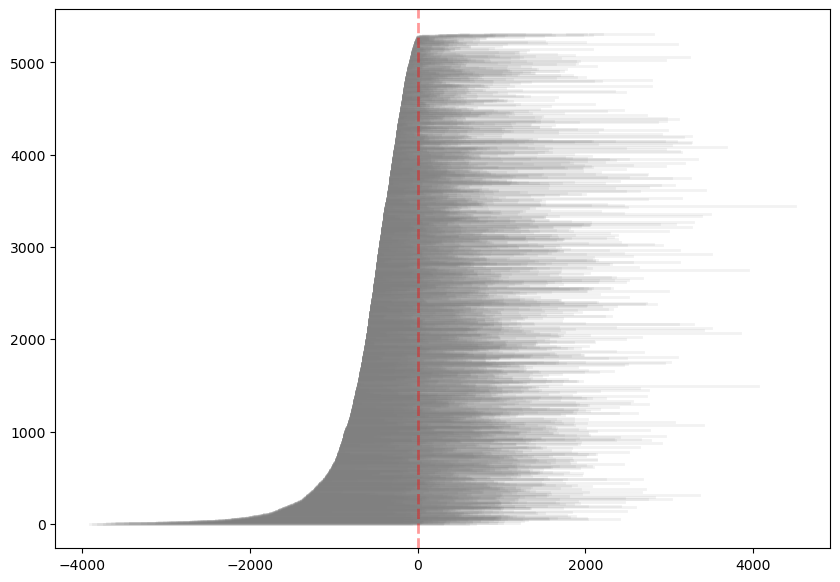

In [637]:
fig, ax = plt.subplots(figsize=(10, 7))

for i, row in tqdm(df.iterrows()): 
    ax.plot([row['Repo_created_at'], row['Repo_updated_at']], [i, i], color='grey', linewidth=2, zorder=1, alpha = 0.1)

ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha = 0.4, zorder=2)       

plt.show()

3878it [00:03, 1151.48it/s]
1434it [00:01, 1090.00it/s]


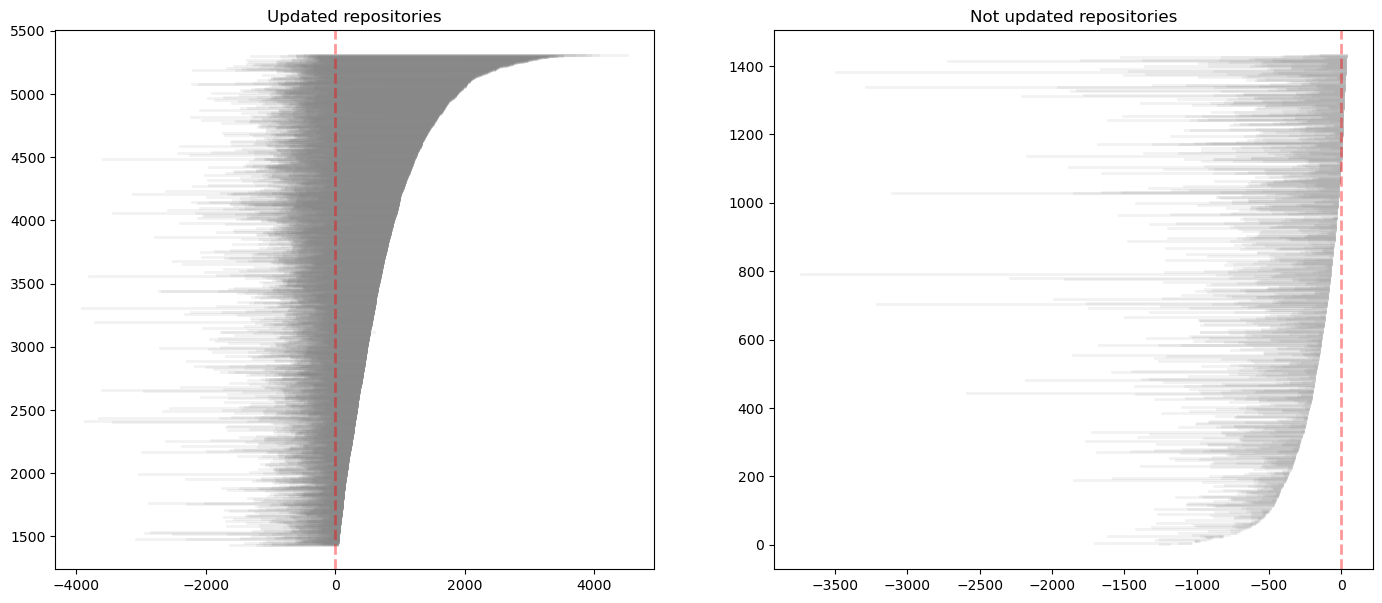

In [640]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

df = df.sort_values(by=['Repo_updated_at', 'Repo_created_at'], ascending=[True, True])
df = df.reset_index(drop=True)

for i, row in tqdm(df[df['Updates'] == 1].iterrows()):
        axs[0].plot([row['Repo_created_at'], row['Repo_updated_at']], [i, i], color='grey', linewidth=2, zorder=1, alpha = 0.1)

for i, row in tqdm(df[df['Updates'] == 0].iterrows()):
        axs[1].plot([row['Repo_created_at'], row['Repo_updated_at']], [i, i], color='grey', linewidth=2, zorder=1, alpha = 0.1)

axs[0].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha = 0.4, zorder=2)  
axs[1].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha = 0.4, zorder=2)  

axs[0].set_title('Updated repositories')
axs[1].set_title('Not updated repositories')

plt.show()

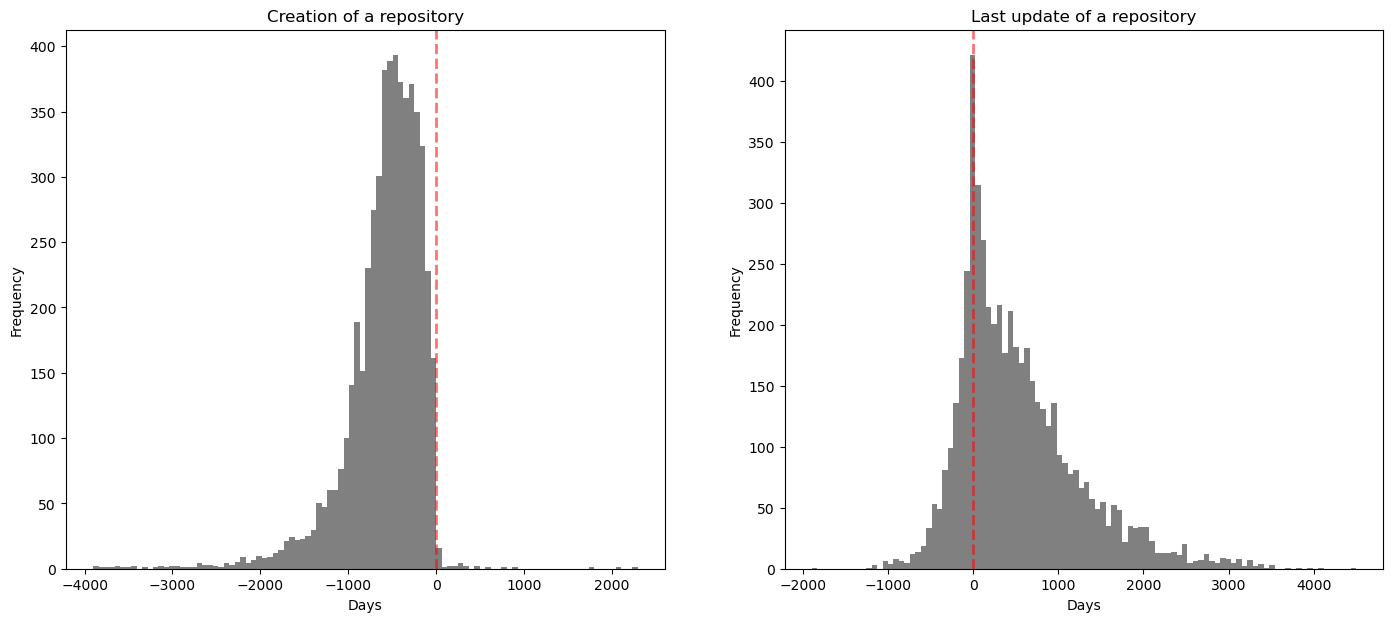

In [633]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

axs[0].hist(df['Repo_created_at'], bins=100, color='grey')
axs[1].hist(df['Repo_updated_at'], bins=100, color='grey')

axs[0].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha = 0.55, zorder=2)    
axs[1].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha = 0.55, zorder=2)   

axs[0].set_xlabel('Days')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Creation of a repository')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Last update of a repository')

plt.show()

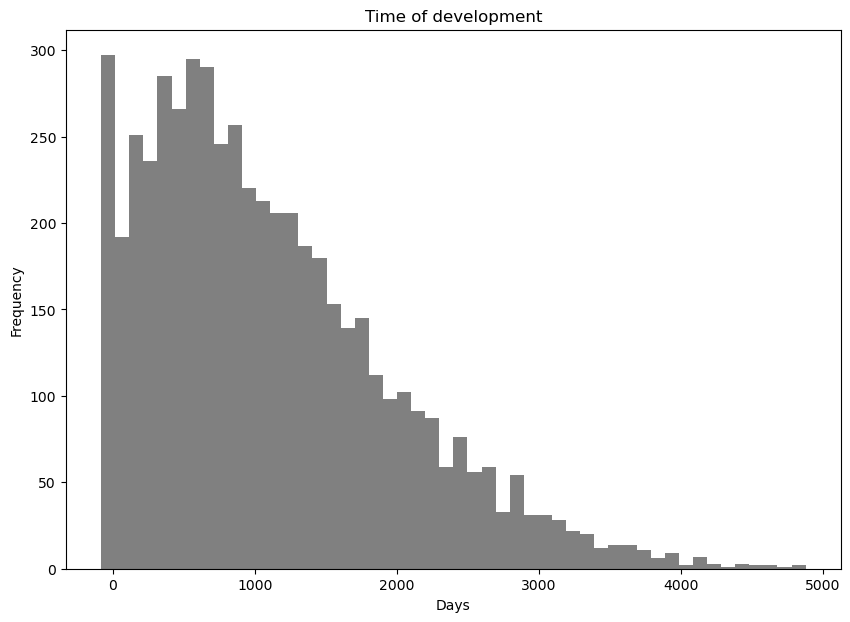

In [634]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.hist((df['Repo_updated_at']-df['Repo_created_at']), bins=50, color='grey')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Time of development')
plt.show()